# CHURN

# Imports

In [72]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
!pip install catboost

In [74]:
!pip install shap

In [75]:
# gestión de datos
import numpy as np
import pandas as pd

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import set_config


# preprocessing
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

# modelos
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier: el equivalente del Adaline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder

# pipelines
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer

# metricas
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# interpretabilidad
import shap

# para visualizar mas columnas en un df
pd.set_option('display.max_columns',None)

# guardar objetos
import pickle

import warnings
warnings.filterwarnings("ignore")  # inhabilita warnings

np.random.seed(42)

In [76]:
set_config(transform_output = "pandas")

In [77]:
df_entrenar = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Nuclio/M4_ML/Aprendizaje_Supervisado/Entregable_2/churn - dataset a entrenar.csv')

In [78]:
df_predecir = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Nuclio/M4_ML/Aprendizaje_Supervisado/Entregable_2/churn - dataset a predecir.csv')

# Business Understanding​

**Problema**: Descenso de clientes activos.

**Objetivo**: Evitar que los clientes se den de baja, ofrecienco condiciones especiales si deciden renovar.

**MISIÓN**
1. Modelizar la predicción de abandono (churn=1) y calcular para 1500 clientes la probabilidad de abandono el próximo mes.

2. Entender que factores(variables), tienen mayor impacto en la decisión del cliente en abandonar.


## EDA: Analisis Exploratorio

In [79]:
df_entrenar.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,blck_vce,blck_dat,unan_vce,plcd_vce,recv_vce,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callwait,churn,months,uniqsubs,actvsubs,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,marital,infobase,income,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.50,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.666667,0.0,6.333333,52.333333,42.333333,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.333333,1,61,2,1,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,M,4.0,3.0,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,55.2300,570.50,71.98,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.666667,0.0,77.000000,222.333333,94.666667,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.000000,0,57,1,1,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,S,M,6.0,1.0,0.0,I,U,U,U,U,U,Y,434.0,1000005
2,82.2750,1312.25,75.00,0.0,0.0,0.0,0.0,156.75,8.1450,52.000000,7.666667,0.0,76.000000,702.000000,365.000000,577.333333,0.0,4.333333,11.000000,7.753333,301.666667,1.333333,369.536667,200.320000,370.333333,243.213333,147.000000,85.146667,555.666667,0.0,382.096667,303.666667,0.0,187.760000,0.0,59.666667,702.000000,577.333333,22.666667,0,59,2,2,C,N,26812,40869.00000,4033.98,3932.90,40295.00,26362,83.68,857.34,560.89,1260,960,80,1187.0,853.0,78.0,U,GREAT LAKES AREA,N,N,129.98999,9.0,4.0,WCMB,0.0,0.0,O,1.0,S,M,6.0,1.0,0.0,U,U,U,U,U,U,Y,458.0,1000006
3,17.1450,0.00,16.99,0.0,0.0,0.0,0.0,0.00,-0.1550,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,53,2,2,A,N,6279,17390.03333,3091.70,3065.24,17371.03,6271,58.95,334.06,120.60,0,0,17,0.0,0.0,17.0,C,DALLAS AREA,Y,N,29.98999,4.0,3.0,NaN,0.0,0.0,O,8.0,M,M,9.0,NaN,0.0,N,U,U,U,U,U,Y,852.0,1000007
4,38.0525,682.50,52.49,0.0,0.0,0.0,0.0,147.50,-3.0625,9.000000,1.666667,0.0,13.000000,97.000000,13.000000,73.333333,0.0,0.666667,5.333333,5.276667,5.000000,0.000000,470.023333,42.196667,6.666667,6.230000,0.000000,0.000000,33.333333,0.0,81.066667,53.000000,0.0,431.153333,0.0,10.666667,97.000000,73.333333,0.666667,0,53,1,1,B,N,4491,12492.00000,1427.71,1423.06,12439.00,4470,34.71,303.39,109.02,633,96,39,719.0,112.0,58.0,NaN,NaN,Y,N,79.98999,3.0,2.0,WCMB,0.0,0.0,R,0.0,M,M,1.0,2.0,1.0,S,U,U,U,U,U,Y,231.0,1000008


In [80]:
df_predecir.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,blck_vce,blck_dat,unan_vce,plcd_vce,recv_vce,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callwait,months,uniqsubs,actvsubs,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,marital,infobase,income,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,31.4475,56.00,30.000,8.75,1.4475,1.4475,0.0000,-34.00,-1.4475,1.000000,0.000000,0.0,2.000000,14.333333,12.000000,11.666667,0.0,0.000000,0.0,0.000000,6.333333,0.0,5.373333,12.700000,0.000000,0.00,1.000000,1.320000,2.333333,0.0,1.406667,21.000000,0.0,16.666667,0.0,1.000000,14.333333,11.666667,0.000000,55,1,1,A,N,5052,7942.00000,2399.93,2352.93,7914.00,5027,44.39,149.32,94.85,67,57,32,61.0,49.0,31.0,S,MIDWEST AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,O,10.0,M,M,7.0,3.0,0.0,G,U,U,U,Y,Y,Y,1646.0,1000055
1,76.7375,1007.75,59.990,65.25,19.5750,19.5750,6.6775,-51.75,5.3625,2.000000,8.666667,0.0,82.000000,392.666667,122.333333,300.000000,0.0,0.000000,0.0,0.000000,58.000000,0.0,390.706667,244.050000,105.000000,54.66,41.000000,74.640000,225.333333,0.0,321.330000,197.000000,0.0,313.426667,0.0,10.666667,392.666667,300.000000,8.666667,52,3,3,A,N,12566,23282.00000,2805.23,2749.73,23077.00,12472,53.92,452.49,244.55,1025,453,75,980.0,462.0,69.0,S,MIDWEST AREA,Y,R,29.98999,7.0,5.0,WCMB,1.0,1.0,O,6.0,M,M,7.0,NaN,0.0,D,U,U,U,U,U,Y,163.0,1000081
2,159.0400,2542.50,75.000,458.25,45.8250,45.8250,9.5600,-225.50,-19.3600,34.333333,3.000000,0.0,178.000000,926.666667,514.333333,725.666667,0.0,0.333333,3.0,2.773333,257.666667,0.0,920.440000,765.296667,285.333333,385.75,129.666667,257.120000,1022.666667,0.0,1476.833333,159.333333,0.0,208.913333,0.0,37.333333,926.666667,725.666667,50.000000,48,5,4,A,N,54269,92628.16667,5166.97,5076.97,92489.17,54179,108.02,1967.85,1152.74,2618,1508,166,2656.0,1527.0,166.0,U,SOUTHWEST AREA,Y,N,29.98999,8.0,6.0,WC,1.0,0.0,O,11.0,M,M,4.0,2.0,0.0,N,U,U,U,U,Y,Y,263.0,1000301
3,67.2750,602.50,50.000,73.25,7.3250,7.3250,4.8000,-155.50,-12.8250,21.666667,0.666667,0.0,36.666667,222.666667,155.666667,169.000000,0.0,0.000000,0.0,0.000000,106.000000,0.0,234.703333,190.406667,44.000000,48.01,5.000000,19.306667,262.666667,0.0,378.946667,34.333333,0.0,46.163333,0.0,22.333333,222.666667,169.000000,1.000000,50,1,1,A,N,23357,47230.00000,4478.24,4386.30,46840.00,23149,91.38,975.83,482.27,654,317,71,1077.0,519.0,103.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,R,99.98999,9.0,4.0,WCMB,0.0,0.0,O,10.0,S,M,2.0,1.0,0.0,N,U,U,U,U,U,Y,204.0,1000444
4,80.2825,1245.25,68.295,73.00,18.2500,18.2500,0.0000,-160.25,-62.0725,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,50,2,1,B,N,66754,122300.50000,6847.28,6748.76,121786.50,66511,140.60,2537.22,1385.65,1299,646,101,1423.0,682.0,99.0,U,SOUTH FLORIDA AREA,N,N,29.98999,8.0,4.0,WC,0.0,0.0,O,1.0,A,M,6.0,2.0,0.0,S,U,U,U,U,U,Y,285.0,1000449


In [81]:
df_entrenar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               50000 non-null  float64
 1   mou               50000 non-null  float64
 2   totmrc            50000 non-null  float64
 3   ovrmou            50000 non-null  float64
 4   ovrrev            50000 non-null  float64
 5   vceovr            50000 non-null  float64
 6   roam              50000 non-null  float64
 7   change_mou        50000 non-null  float64
 8   change_rev        50000 non-null  float64
 9   drop_vce          50000 non-null  float64
 10  blck_vce          50000 non-null  float64
 11  blck_dat          50000 non-null  float64
 12  unan_vce          50000 non-null  float64
 13  plcd_vce          50000 non-null  float64
 14  recv_vce          50000 non-null  float64
 15  comp_vce          50000 non-null  float64
 16  comp_dat          50000 non-null  float6

In [82]:
df_predecir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 85 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               1500 non-null   float64
 1   mou               1500 non-null   float64
 2   totmrc            1500 non-null   float64
 3   ovrmou            1500 non-null   float64
 4   ovrrev            1500 non-null   float64
 5   vceovr            1500 non-null   float64
 6   roam              1475 non-null   float64
 7   change_mou        1500 non-null   float64
 8   change_rev        1500 non-null   float64
 9   drop_vce          1500 non-null   float64
 10  blck_vce          1500 non-null   float64
 11  blck_dat          1500 non-null   float64
 12  unan_vce          1500 non-null   float64
 13  plcd_vce          1500 non-null   float64
 14  recv_vce          1500 non-null   float64
 15  comp_vce          1500 non-null   float64
 16  comp_dat          1500 non-null   float64


In [83]:
df_entrenar.describe()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,blck_vce,blck_dat,unan_vce,plcd_vce,recv_vce,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callwait,churn,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,lor,income,numbcars,forgntvl,eqpdays,Customer_ID
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,36287.000000,38688.000000,26519.000000,50000.000000,50000.000000,5.000000e+04
mean,59.592453,525.927840,46.757288,42.251626,13.682811,13.423204,1.384443,-14.118840,-1.280641,6.045740,4.222187,0.024853,28.288373,148.592847,57.411587,111.863240,0.805267,1.802427,4.756413,3.771664,31.068680,0.290647,231.383743,115.617511,25.579333,29.342064,8.270033,18.900160,91.277600,0.372393,179.251520,68.209887,0.432880,167.694938,1.212593,10.338493,149.500193,112.668507,1.910867,0.450980,19.442880,1.545260,1.363400,3130.523200,8253.872341,1098.410996,1027.070202,8155.329963,3090.61194,58.132370,484.146258,176.281934,531.81194,186.431160,60.107620,522.115420,184.099420,59.493900,102.484391,1.866500,1.600760,0.198920,0.08816,6.259184,5.804513,1.568724,0.060240,390.685960,1.044602e+06
std,49.442525,541.537185,24.141474,102.904894,31.589805,31.226904,19.091658,292.666852,59.347247,9.179373,11.478934,0.903324,39.548744,164.621906,93.405323,123.639793,8.453882,6.004579,13.612671,11.194417,61.297597,1.098148,267.330716,169.642105,35.908462,51.226123,17.004914,42.466505,108.477139,4.239446,217.856705,95.944614,4.806435,237.503680,20.296706,16.212728,165.681385,124.639232,5.762129,0.497596,9.299169,0.886435,0.639491,4213.464385,9546.380677,928.640998,914.325316,9475.838455,4179.58089,37.056075,440.897343,174.671107,549.80530,203.431386,48.970008,512.310681,192.617838,42.651082,61.442440,1.386289,0.937307,0.399192,0.28353,4.762210,2.189491,0.631659,0.237933,251.122428,2.608113e+04
min,0.885000,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,-3406.500000,-1107.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,23.750000,17.460000,0.000000,0.00000,2.910000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,-2.000000,9.989998,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,-5.000000,1.000001e+06
25%,33.250000,155.500000,30.000000,0.000000,0.000000,0.000000,0.000000,-85.500000,-7.320000,0.666667,0.000000,0.000000,5.000000,38.666667,5.333333,29.000000,0.000000,0.000000,0.000000,0.000000,2.333333,0.000000,50.719167,7.549167,3.000000,2.412500,0.000000,0.000000,21.666667,0.000000,38.287500,10.583333,0.000000,19.357500,0.000000,1.666667,39.000000,29.000000,0.000000,0.000000,12.000000,1.000000,1.000000,936.000000,2671.000000,550.817500,484.677500,2618.000000,918.00000,35.250000,177.00000

In [84]:
df_predecir.describe()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,blck_vce,blck_dat,unan_vce,plcd_vce,recv_vce,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callwait,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,lor,income,numbcars,forgntvl,eqpdays,Customer_ID
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1475.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1110.000000,1195.000000,824.000000,1500.000000,1500.000000,1.500000e+03
mean,60.334351,528.294556,48.244583,38.955667,12.633597,12.353563,1.808710,-21.631222,-1.864644,5.950000,4.393111,0.037556,27.364000,145.791111,54.254000,109.833778,0.954889,1.679778,4.561111,3.645264,28.611556,0.264667,229.710058,112.838524,24.878667,28.502160,7.860000,17.924244,90.767111,0.498444,180.704369,64.710889,0.456444,161.804209,0.965784,10.415778,146.854000,110.788667,1.858889,19.446667,1.563333,1.363333,3175.994000,8363.618491,1111.621120,1037.201227,8258.371827,3132.969333,59.113413,489.843033,177.906400,537.974667,186.226000,61.183333,527.750667,185.494000,60.207333,101.716657,1.872000,1.604667,0.200667,0.088667,6.344144,5.849372,1.598301,0.059333,397.002667,1.044637e+06
std,48.824061,534.340118,28.118878,89.104242,27.966827,27.844371,17.813865,264.556499,38.688326,8.495074,10.548056,0.561928,36.559393,152.084395,76.058328,115.315296,8.739535,3.575034,9.863311,8.511347,44.059420,0.841415,257.060410,158.346894,33.789061,43.873195,15.028275,38.449947,105.085926,5.423828,216.293598,84.663393,4.677973,227.828631,8.503404,14.745757,153.294116,116.538672,4.752445,9.100606,0.945825,0.647767,4478.630969,9764.665398,898.487421,884.115262,9698.255054,4445.736723,38.354519,440.299260,171.773465,550.749835,196.729691,53.618091,519.758050,191.007279,46.153416,60.433324,1.429561,0.956201,0.400633,0.284357,4.674098,2.147198,0.617719,0.236326,258.186313,2.617746e+04
min,0.582500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2070.250000,-673.355000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,12.000000,27.000000,68.650000,62.460000,17.000000,8.000000,7.140000,1.420000,0.670000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,9.989998,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-3.000000,1.000055e+06
25%,32.883125,146.500000,30.000000,0.000000,0.000000,0.000000,0.000000,-89.000000,-7.568750,0.666667,0.000000,0.000000,4.666667,36.333333,4.333333,26.666667,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,49.539167,5.969167,3.000000,2.405000,0.000000,0.000000,18.666667,0.000000,33.173333,9.666667,0.000000,18.628333,0.000000,1.666667,36.333333,26.666667,0.000000,12.000000,1.000000,1.000000,918.500000,2611.000000,551.645000,487.152500,2552.250000,908.000000,34.612500,174.417500,61.322500,148.000000,53.000000,33.000000,162.000000,55.750000,34.000000,29.989990,1.000000,1.000000,0.000000,0.000

In [85]:
df_entrenar.shape

(50000, 86)

In [86]:
df_predecir.shape

(1500, 85)

### **Valores negativos**

In [87]:
# negat_value= []

# for col in df_entrenar.columns:
#   if  (df_entrenar[col].dtype.kind =='i' or df_entrenar[col].dtype.kind =='f') and (df_entrenar[col] < 0).any():
#     negat_value.append(col)

# print(negat_value)

In [88]:
# negat_value= []

# for col in df_predecir.columns:
#   if  (df_predecir[col].dtype.kind =='i' or df_predecir[col].dtype.kind =='f') and (df_predecir[col] < 0).any():
#     negat_value.append(col)

# print(negat_value)

In [89]:
# valores raros que sean negativos: ['totmrc',''avg6rev', 'eqpdays' ]

In [90]:
# # ponemos todos los valores en positivo
# df_entrenar['totmrc'] = np.abs(df_entrenar['totmrc'])
# df_entrenar['avg6rev'] = np.abs(df_entrenar['avg6rev'])
# df_entrenar['eqpdays'] = np.abs(df_entrenar['eqpdays'])

# df_predecir['eqpdays'] = np.abs(df_predecir['eqpdays'])

### Distribución de la target

In [91]:
target = 'churn'

In [92]:
df_entrenar[target].value_counts(normalize= True)*100

,proportion
churn,
0,54.902
1,45.098


### Analisis univariable

In [93]:
# # Distribución de las variables según el tipo de variable
# def EDA_variables (dataframe):
#   for column in dataframe.columns:
#     if  dataframe[column].dtypes.kind == 'f' or dataframe[column].dtypes.kind== 'i':
#       print(dataframe.hist(column))

#     elif dataframe[column].dtypes.kind== 'O' or dataframe[column].dtypes.kind== 'b':
#       print(dataframe[column].value_counts(normalize=True))

In [94]:
# EDA_variables(df_entrenar)

### Analisis variables-target

In [95]:
# Identifica el tipo de variables del dataset de entrada

def obtener_lista_variable(dataset):
  lista_numericas = []
  lista_boolen=[]
  lista_categoricas = []



  for column in dataset.columns:
    if (dataset[column].dtype.kind == 'i' or dataset[column].dtype.kind=='f') and len(dataset[column].unique())==2 and column not in target:
      lista_boolen.append(column)
    elif (dataset[column].dtype.kind == 'i' or dataset[column].dtype.kind=='f') and len(dataset[column].unique())!=2 and column not in target:
      lista_numericas.append(column)
    elif dataset[column].dtype.kind == 'O' and column not in target:
      lista_categoricas.append(column)


  return lista_numericas, lista_boolen, lista_categoricas

In [96]:
lista_numericas, lista_boolen, lista_categoricas= obtener_lista_variable(df_entrenar)

In [97]:
lista_numericas

['rev',
 'mou',
 'totmrc',
 'ovrmou',
 'ovrrev',
 'vceovr',
 'roam',
 'change_mou',
 'change_rev',
 'drop_vce',
 'blck_vce',
 'blck_dat',
 'unan_vce',
 'plcd_vce',
 'recv_vce',
 'comp_vce',
 'comp_dat',
 'custcare',
 'ccrndmou',
 'cc_mou',
 'inonemin',
 'threeway',
 'mou_cvce',
 'mou_rvce',
 'owylis_vce',
 'mouowylisv',
 'iwylis_vce',
 'mouiwylisv',
 'peak_vce',
 'peak_dat',
 'mou_peav',
 'opk_vce',
 'opk_dat',
 'mou_opkv',
 'mou_opkd',
 'drop_blk',
 'attempt',
 'complete',
 'callwait',
 'months',
 'uniqsubs',
 'actvsubs',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou',
 'avg3qty',
 'avg3rev',
 'avg6mou',
 'avg6qty',
 'avg6rev',
 'hnd_price',
 'phones',
 'models',
 'lor',
 'income',
 'numbcars',
 'eqpdays',
 'Customer_ID']

In [98]:
lista_categoricas

['crclscod',
 'asl_flag',
 'prizm_social_one',
 'area',
 'dualband',
 'refurb_new',
 'hnd_webcap',
 'ownrent',
 'marital',
 'infobase',
 'ethnic',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd']

In [99]:
lista_boolen

['truck', 'rv', 'forgntvl']

#### **Variables categóricas y variables booleanas**

In [100]:
# def variables_cat_bool_VS_target (df, lista_categoricas, lista_boolen):
#   for i in df:
#     if i in lista_categoricas or i in lista_boolen:
#       plt.figure(figsize=(14,5))
#       sns.violinplot(x=i, y=target, data = df, palette= 'Wistia')

In [101]:
# variables_cat_bool_VS_target(df_entrenar, lista_categoricas, lista_boolen)

#### **Variables numéricas**

In [102]:
# def variables_num_VS_target (df, lista_numericas):
#   for i in df:
#     if i in lista_numericas:
#       plt.figure(figsize=(14,5))
#       sns.scatterplot(x= i,  y = target, data= df)

In [103]:
# variables_num_VS_target(df_entrenar,lista_numericas)

# Preprocessing

## Data Cleaning

In [104]:
df_duplicados= pd.DataFrame()
df_duplicados['duplicados_entrenar']= df_entrenar.duplicated().sum()
df_duplicados['duplicados_predecir']= df_predecir.duplicated().sum()



In [105]:
df_duplicados

,duplicados_entrenar,duplicados_predecir


## Tratamiento de nulos

In [106]:
pd.set_option('display.max_rows', None)
df_nulos= pd.DataFrame()
df_nulos['nulos_entrenar']= round(df_entrenar.isnull().sum()/len(df_entrenar)*100, 3)
df_nulos['nulos_predecir']= round(df_predecir.isnull().sum()/len(df_predecir)*100, 3)
df_nulos = df_nulos[(df_nulos['nulos_entrenar'] > 0) | (df_nulos['nulos_predecir'] > 0)]

In [107]:
df_nulos

,nulos_entrenar,nulos_predecir
roam,0.000,1.667
prizm_social_one,6.584,5.867
area,1.440,0.000
dualband,0.000,1.667
hnd_webcap,9.942,10.333
ownrent,30.892,28.467
lor,27.426,26.000
infobase,19.580,17.467
income,22.624,20.333
numbcars,46.962,45.067


- numbcars :eliminarla
- income: 'desconocida'
- infobase: 'desconocida'
- lor: INVESTIGAR
- ownrent: 'desconocida'
- hnd_webcap:INVESTIGAR
- dualband: moda
- area: moda
- prizm_social_one: 'desconocida'
-roam: media
Probar BFILL() Y FFILL()

- numbcars :0
- income: 'desconocida'
- infobase: 'desconocida'
- lor: INVESTIGAR
- ownrent: 'desconocida'
- hnd_webcap:INVESTIGAR
- dualband: moda
- area: moda
- prizm_social_one: 'desconocida'
-roam: media
Probar BFILL() Y FFILL()


PROBAR MODELO, SIGUIENTE PASO: AGRUPAR LAS CATEGÓRICAS EN CATEGORIAS MÁS REPRESENTATIVAS.


In [108]:
ct = ColumnTransformer(
    transformers= [
        ('median_roam', SimpleImputer(strategy= 'median'), ['roam']),
        ('unknown', SimpleImputer(strategy= 'constant',fill_value= 'unknown'), ['prizm_social_one','hnd_webcap', 'ownrent','infobase']),
        ('mode', SimpleImputer(strategy= 'most_frequent'), ['area', 'dualband']),
        ('0_lor', SimpleImputer(strategy= 'constant',fill_value= 0), ['lor']),
        ('median_income', SimpleImputer(strategy= 'median'), ['income']),
        ('0_numbcar', SimpleImputer(strategy= 'constant',fill_value= 0), ['numbcars'])
    ],
    remainder='passthrough'
)

In [109]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('median_roam',
                                 SimpleImputer(strategy='median'), ['roam']),
                                ('unknown',
                                 SimpleImputer(fill_value='unknown',
                                               strategy='constant'),
                                 ['prizm_social_one', 'hnd_webcap', 'ownrent',
                                  'infobase']),
                                ('mode',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['area', 'dualband']),
                                ('0_lor',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['lor']),
                                ('median_income',
                                 SimpleImputer(strategy='median'), ['income']),
                                ('0_numbcar',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['numbcars'])])

In [110]:
for col in df_entrenar.columns:
  if col in df_nulos.index:
    print( f'{col}: {df_entrenar[col].dtypes}')

roam: float64
prizm_social_one: object
area: object
dualband: object
hnd_webcap: object
ownrent: object
lor: float64
infobase: object
income: float64
numbcars: float64


In [111]:
# eliminar el target de df_train
# pasar column transform
# volver a pegar el target
y= df_entrenar[target]

In [112]:
df_entrenar= df_entrenar.drop(columns= target)

In [113]:
df_entrenar_t= ct.fit_transform(df_entrenar)
df_predecir_t=ct.transform(df_predecir)

In [114]:
df_entrenar_t = pd.concat([df_entrenar_t, y], axis=1)

In [115]:
df_entrenar_t.shape

(50000, 86)

In [116]:
df_predecir_t.shape

(1500, 85)

## Tratamiento de variables categóricas

In [117]:
# Identifica el tipo de variables del dataset de entrada

def obtener_lista_variable(dataset):
  lista_numericas = []
  lista_boolen=[]
  lista_categoricas = []



  for column in dataset.columns:
    if (dataset[column].dtype.kind=='O') and len(dataset[column].unique())==2 and column not in target:
      lista_boolen.append(column)
    elif (dataset[column].dtype.kind == 'i' or dataset[column].dtype.kind=='f') and len(dataset[column].unique())!=2 and column not in target:
      lista_numericas.append(column)
    elif dataset[column].dtype.kind == 'O' and column not in target:
      lista_categoricas.append(column)


  return lista_numericas, lista_boolen, lista_categoricas

In [118]:
lista_numericas, lista_boolen, lista_categoricas = obtener_lista_variable(df_entrenar_t)

In [119]:
lista_boolen

['unknown__infobase',
 'remainder__asl_flag',
 'remainder__refurb_new',
 'remainder__kid0_2',
 'remainder__kid3_5',
 'remainder__kid6_10',
 'remainder__kid11_15',
 'remainder__kid16_17',
 'remainder__creditcd']

In [120]:
lista_categoricas

['unknown__prizm_social_one',
 'unknown__hnd_webcap',
 'unknown__ownrent',
 'mode__area',
 'mode__dualband',
 'remainder__crclscod',
 'remainder__marital',
 'remainder__ethnic']

### Booleanas

In [121]:
for column in df_entrenar_t.columns:
  if column in lista_boolen:
    print(df_entrenar_t[column].value_counts(normalize= True))


unknown__infobase
M          0.8042
unknown    0.1958
Name: proportion, dtype: float64
remainder__asl_flag
N    0.8778
Y    0.1222
Name: proportion, dtype: float64
remainder__refurb_new
N    0.85122
R    0.14878
Name: proportion, dtype: float64
remainder__kid0_2
U    0.95884
Y    0.04116
Name: proportion, dtype: float64
remainder__kid3_5
U    0.95296
Y    0.04704
Name: proportion, dtype: float64
remainder__kid6_10
U    0.91722
Y    0.08278
Name: proportion, dtype: float64
remainder__kid11_15
U    0.90918
Y    0.09082
Name: proportion, dtype: float64
remainder__kid16_17
U    0.89604
Y    0.10396
Name: proportion, dtype: float64
remainder__creditcd
Y    0.70354
N    0.29646
Name: proportion, dtype: float64


In [122]:
df_entrenar_t = pd.get_dummies(df_entrenar_t, columns= lista_boolen, drop_first= True)

In [123]:
df_predecir_t= pd.get_dummies(df_predecir_t, columns= lista_boolen, drop_first= True)

In [124]:
df_entrenar_t.shape

(50000, 86)

In [125]:
df_predecir_t.shape

(1500, 85)

### Categóricas

In [126]:
for column in df_entrenar_t.columns:
  if column in lista_categoricas:
    print(df_entrenar_t[column].value_counts(normalize= True))

unknown__prizm_social_one
S          0.32724
U          0.23784
C          0.17016
T          0.15136
unknown    0.06584
R          0.04756
Name: proportion, dtype: float64
unknown__hnd_webcap
WCMB       0.77102
WC         0.12956
unknown    0.09942
Name: proportion, dtype: float64
unknown__ownrent
O          0.67118
unknown    0.30892
R          0.01990
Name: proportion, dtype: float64
mode__area
NEW YORK CITY AREA               0.12980
DC/MARYLAND/VIRGINIA AREA        0.06676
MIDWEST AREA                     0.06578
ATLANTIC SOUTH AREA              0.06058
CALIFORNIA NORTH AREA            0.05910
DALLAS AREA                      0.05688
NEW ENGLAND AREA                 0.05340
SOUTHWEST AREA                   0.05266
CHICAGO AREA                     0.05156
LOS ANGELES AREA                 0.04860
GREAT LAKES AREA                 0.04842
OHIO AREA                        0.04840
HOUSTON AREA                     0.04290
CENTRAL/SOUTH TEXAS AREA         0.04278
NORTH FLORIDA AREA       

In [127]:
# Ahora haremos one Hot encoder para transformarlas a numéricas.
# 1. Entrenamos y transformamos columnas
oe= OneHotEncoder(handle_unknown='ignore', sparse_output= False,dtype= int)
X_encoded_train= oe.fit_transform(df_entrenar_t[lista_categoricas])
X_encoded_pred = oe.transform(df_predecir_t[lista_categoricas])

2# Concatenar las variables transformadas.
categorical_feature_names = oe.get_feature_names_out(lista_categoricas)
X_df_categorico_encoded = pd.DataFrame(X_encoded_train, columns=categorical_feature_names, index=df_entrenar.index)
y_df_categorico_encoded = pd.DataFrame(X_encoded_pred, columns=categorical_feature_names, index=df_predecir.index)

df_entrenar_t2 = pd.concat([df_entrenar_t,X_df_categorico_encoded], axis=1).drop(columns=lista_categoricas)
df_predecir_t2 = pd.concat([df_predecir_t,y_df_categorico_encoded], axis=1).drop(columns=lista_categoricas)


In [128]:
df_entrenar_t2.shape

(50000, 184)

In [129]:
df_predecir_t2.shape

(1500, 183)

###Customer_ID

In [130]:
df_entrenar_t2.columns

Index(['median_roam__roam', '0_lor__lor', 'median_income__income',
       '0_numbcar__numbcars', 'remainder__rev', 'remainder__mou',
       'remainder__totmrc', 'remainder__ovrmou', 'remainder__ovrrev',
       'remainder__vceovr',
       ...
       'remainder__ethnic_J', 'remainder__ethnic_M', 'remainder__ethnic_N',
       'remainder__ethnic_O', 'remainder__ethnic_P', 'remainder__ethnic_R',
       'remainder__ethnic_S', 'remainder__ethnic_U', 'remainder__ethnic_X',
       'remainder__ethnic_Z'],
      dtype='object', length=184)

In [131]:
#Eliminamos el customer_ID de df_entrenar y el de df_predecir lo guardamos en una variable y lo eliminamos para continuar.

df_entrenar_t2.drop(columns= 'remainder__Customer_ID', axis=1, inplace= True)

cust_id_pred= df_predecir_t2['remainder__Customer_ID']
df_predecir_t2.drop(columns= 'remainder__Customer_ID', axis=1, inplace= True)

## alta correlación

al tener tantas variables no vamos a graficar las correlaciones

In [132]:
df_corr = df_entrenar_t2.corr(numeric_only=True)

# creamos un dataframe triangulo de las correlaciones para evitar que se repitan los valores
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df_entrenar_t2.columns)
df_triangulo.index = df_entrenar_t2.columns

In [133]:
# Seleccionamos los pares de variables cuya correlación absoluta supere el umbral de 0.9
df_altas_correlaciones = df_triangulo.stack().reset_index()
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.9]

In [134]:
# sacamos las correlaciones de las variables con la target
corr_con_target = df_entrenar_t2.corr()[target]

In [135]:
# añadimos las correlaciones al DataFrame de altas correlaciones
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

In [136]:
# añadimos la variable menos correlacionada con la target del par de variables altamente correlaciones
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(
    lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
788,remainder__rev,remainder__avg3rev,0.916263,-0.042755,-0.049085,remainder__rev
969,remainder__mou,remainder__avg3mou,0.981792,-0.136841,-0.121849,remainder__avg3mou
972,remainder__mou,remainder__avg6mou,0.946929,-0.136841,-0.113166,remainder__avg6mou
1289,remainder__ovrmou,remainder__ovrrev,0.952835,0.033961,0.045001,remainder__ovrmou
1290,remainder__ovrmou,remainder__vceovr,0.949790,0.033961,0.046113,remainder__ovrmou
1473,remainder__ovrrev,remainder__vceovr,0.994986,0.045001,0.046113,remainder__ovrrev
2946,remainder__plcd_vce,remainder__comp_vce,0.985531,-0.110247,-0.117977,remainder__plcd_vce
2967,remainder__plcd_vce,remainder__attempt,0.998374,-0.110247,-0.110687,remainder__plcd_vce
2968,remainder__plcd_vce,remainder__complete,0.983301,-0.110247,-0.118414,remainder__plcd_vce
3134,remainder__recv_vce,remainder__inonemin,0.965658,-0.091021,-0.073544,remainder__inonemin


In [137]:
# de las variables altamentes correlacionadas, eliminamos las menos correlacionadas con la target
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))
var_menos_corr

['remainder__avgmou',
 'remainder__totcalls',
 'remainder__totmou',
 'remainder__rev',
 'remainder__attempt',
 'remainder__ovrmou',
 'remainder__adjqty',
 'remainder__peak_vce',
 'remainder__totrev',
 'remainder__cc_mou',
 'remainder__opk_dat',
 'remainder__comp_vce',
 'remainder__inonemin',
 'remainder__ovrrev',
 'remainder__plcd_vce',
 'remainder__avgqty',
 'unknown__ownrent_unknown',
 'remainder__avg3rev',
 'remainder__avg6mou',
 'remainder__peak_dat',
 'remainder__avg3mou',
 'remainder__avg6qty']

In [138]:
df_entrenar_t2.drop(columns=var_menos_corr, inplace=True)
df_entrenar_t2.head()

,median_roam__roam,0_lor__lor,median_income__income,0_numbcar__numbcars,remainder__mou,remainder__totmrc,remainder__vceovr,remainder__change_mou,remainder__change_rev,remainder__drop_vce,remainder__blck_vce,remainder__blck_dat,remainder__unan_vce,remainder__recv_vce,remainder__comp_dat,remainder__custcare,remainder__ccrndmou,remainder__threeway,remainder__mou_cvce,remainder__mou_rvce,remainder__owylis_vce,remainder__mouowylisv,remainder__iwylis_vce,remainder__mouiwylisv,remainder__mou_peav,remainder__opk_vce,remainder__mou_opkv,remainder__mou_opkd,remainder__drop_blk,remainder__complete,remainder__callwait,remainder__months,remainder__uniqsubs,remainder__actvsubs,remainder__adjrev,remainder__adjmou,remainder__avgrev,remainder__avg3qty,remainder__avg6rev,remainder__hnd_price,remainder__phones,remainder__models,remainder__truck,remainder__rv,remainder__forgntvl,remainder__eqpdays,churn,unknown__infobase_unknown,remainder__asl_flag_Y,remainder__refurb_new_R,remainder__kid0_2_Y,remainder__kid3_5_Y,remainder__kid6_10_Y,remainder__kid11_15_Y,remainder__kid16_17_Y,remainder__creditcd_Y,unknown__prizm_social_one_C,unknown__prizm_social_one_R,unknown__prizm_social_one_S,unknown__prizm_social_one_T,unknown__prizm_social_one_U,unknown__prizm_social_one_unknown,unknown__hnd_webcap_WC,unknown__hnd_webcap_WCMB,unknown__hnd_webcap_unknown,unknown__ownrent_O,unknown__ownrent_R,mode__area_ATLANTIC SOUTH AREA,mode__area_CALIFORNIA NORTH AREA,mode__area_CENTRAL/SOUTH TEXAS AREA,mode__area_CHICAGO AREA,mode__area_DALLAS AREA,mode__area_DC/MARYLAND/VIRGINIA AREA,mode__area_GREAT LAKES AREA,mode__area_HOUSTON AREA,mode__area_LOS ANGELES AREA,mode__area_MIDWEST AREA,mode__area_NEW ENGLAND AREA,mode__area_NEW YORK CITY AREA,mode__area_NORTH FLORIDA AREA,mode__area_NORTHWEST/ROCKY MOUNTAIN AREA,mode__area_OHIO AREA,mode__area_PHILADELPHIA AREA,mode__area_SOUTH FLORIDA AREA,mode__area_SOUTHWEST AREA,mode__area_TENNESSEE AREA,mode__dualband_N,mode__dualband_T,mode__dualband_Y,remainder__crclscod_A,remainder__crclscod_A2,remainder__crclscod_A3,remainder__crclscod_AA,remainder__crclscod_B,remainder__crclscod_B2,remainder__crclscod_BA,remainder__crclscod_C,remainder__crclscod_C2,remainder__crclscod_C5,remainder__crclscod_CA,remainder__crclscod_CC,remainder__crclscod_CY,remainder__crclscod_D,remainder__crclscod_D2,remainder__crclscod_D4,remainder__crclscod_D5,remainder__crclscod_DA,remainder__crclscod_E,remainder__crclscod_E2,remainder__crclscod_E4,remainder__crclscod_EA,remainder__crclscod_EC,remainder__crclscod_EF,remainder__crclscod_EM,remainder__crclscod_G,remainder__crclscod_GA,remainder__crclscod_GY,remainder__crclscod_H,remainder__crclscod_I,remainder__crclscod_IF,remainder__crclscod_J,remainder__crclscod_JF,remainder__crclscod_K,remainder__crclscod_M,remainder__crclscod_O,remainder__crclscod_P1,remainder__crclscod_TP,remainder__crclscod_U,remainder__crclscod_U1,remainder__crclscod_V1,remainder__crclscod_W,remainder__crclscod_Y,remainder__crclscod_Z,remainder__crclscod_Z1,remainder__crclscod_Z2,remainder__crclscod_Z4,remainder__crclscod_Z5,remainder__crclscod_ZA,remainder__crclscod_ZF,remainder__crclscod_ZY,remainder__marital_A,remainder__marital_B,remainder__marital_M,remainder__marital_S,remainder__marital_U,remainder__ethnic_B,remainder__ethnic_D,remainder__ethnic_F,remainder__ethnic_G,remainder__ethnic_H,remainder__ethnic_I,remainder__ethnic_J,remainder__ethnic_M,remainder__ethnic_N,remainder__ethnic_O,remainder__ethnic_P,remainder__ethnic_R,remainder__ethnic_S,remainder__ethnic_U,remainder__ethnic_X,remainder__ethnic_Z
0,0.0,15.0,4.0,3.0,219.25,22.50,0.0,-157.25,-18.9975,0.666667,0.666667,0.0,6.333333,42.333333,0.0,0.000000,0.000000,0.000000,90.643333,97.176667,0.000000,0.000000,0.000000,0.000000,132.600000,24.000000,55.220000,0.0,1.333333,45.000000,0.333333,61,2,1,1453.44,4085.00,29.66,116,38.0,149.98999,2.0,2.0,0.0,0.0,0.0,361.0,1,False,False,False,False,False,False,False,False,True,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [139]:
df_predecir_t2.drop(columns=var_menos_corr, inplace=True)
df_predecir_t2.head()

,median_roam__roam,0_lor__lor,median_income__income,0_numbcar__numbcars,remainder__mou,remainder__totmrc,remainder__vceovr,remainder__change_mou,remainder__change_rev,remainder__drop_vce,remainder__blck_vce,remainder__blck_dat,remainder__unan_vce,remainder__recv_vce,remainder__comp_dat,remainder__custcare,remainder__ccrndmou,remainder__threeway,remainder__mou_cvce,remainder__mou_rvce,remainder__owylis_vce,remainder__mouowylisv,remainder__iwylis_vce,remainder__mouiwylisv,remainder__mou_peav,remainder__opk_vce,remainder__mou_opkv,remainder__mou_opkd,remainder__drop_blk,remainder__complete,remainder__callwait,remainder__months,remainder__uniqsubs,remainder__actvsubs,remainder__adjrev,remainder__adjmou,remainder__avgrev,remainder__avg3qty,remainder__avg6rev,remainder__hnd_price,remainder__phones,remainder__models,remainder__truck,remainder__rv,remainder__forgntvl,remainder__eqpdays,unknown__infobase_unknown,remainder__asl_flag_Y,remainder__refurb_new_R,remainder__kid0_2_Y,remainder__kid3_5_Y,remainder__kid6_10_Y,remainder__kid11_15_Y,remainder__kid16_17_Y,remainder__creditcd_Y,unknown__prizm_social_one_C,unknown__prizm_social_one_R,unknown__prizm_social_one_S,unknown__prizm_social_one_T,unknown__prizm_social_one_U,unknown__prizm_social_one_unknown,unknown__hnd_webcap_WC,unknown__hnd_webcap_WCMB,unknown__hnd_webcap_unknown,unknown__ownrent_O,unknown__ownrent_R,mode__area_ATLANTIC SOUTH AREA,mode__area_CALIFORNIA NORTH AREA,mode__area_CENTRAL/SOUTH TEXAS AREA,mode__area_CHICAGO AREA,mode__area_DALLAS AREA,mode__area_DC/MARYLAND/VIRGINIA AREA,mode__area_GREAT LAKES AREA,mode__area_HOUSTON AREA,mode__area_LOS ANGELES AREA,mode__area_MIDWEST AREA,mode__area_NEW ENGLAND AREA,mode__area_NEW YORK CITY AREA,mode__area_NORTH FLORIDA AREA,mode__area_NORTHWEST/ROCKY MOUNTAIN AREA,mode__area_OHIO AREA,mode__area_PHILADELPHIA AREA,mode__area_SOUTH FLORIDA AREA,mode__area_SOUTHWEST AREA,mode__area_TENNESSEE AREA,mode__dualband_N,mode__dualband_T,mode__dualband_Y,remainder__crclscod_A,remainder__crclscod_A2,remainder__crclscod_A3,remainder__crclscod_AA,remainder__crclscod_B,remainder__crclscod_B2,remainder__crclscod_BA,remainder__crclscod_C,remainder__crclscod_C2,remainder__crclscod_C5,remainder__crclscod_CA,remainder__crclscod_CC,remainder__crclscod_CY,remainder__crclscod_D,remainder__crclscod_D2,remainder__crclscod_D4,remainder__crclscod_D5,remainder__crclscod_DA,remainder__crclscod_E,remainder__crclscod_E2,remainder__crclscod_E4,remainder__crclscod_EA,remainder__crclscod_EC,remainder__crclscod_EF,remainder__crclscod_EM,remainder__crclscod_G,remainder__crclscod_GA,remainder__crclscod_GY,remainder__crclscod_H,remainder__crclscod_I,remainder__crclscod_IF,remainder__crclscod_J,remainder__crclscod_JF,remainder__crclscod_K,remainder__crclscod_M,remainder__crclscod_O,remainder__crclscod_P1,remainder__crclscod_TP,remainder__crclscod_U,remainder__crclscod_U1,remainder__crclscod_V1,remainder__crclscod_W,remainder__crclscod_Y,remainder__crclscod_Z,remainder__crclscod_Z1,remainder__crclscod_Z2,remainder__crclscod_Z4,remainder__crclscod_Z5,remainder__crclscod_ZA,remainder__crclscod_ZF,remainder__crclscod_ZY,remainder__marital_A,remainder__marital_B,remainder__marital_M,remainder__marital_S,remainder__marital_U,remainder__ethnic_B,remainder__ethnic_D,remainder__ethnic_F,remainder__ethnic_G,remainder__ethnic_H,remainder__ethnic_I,remainder__ethnic_J,remainder__ethnic_M,remainder__ethnic_N,remainder__ethnic_O,remainder__ethnic_P,remainder__ethnic_R,remainder__ethnic_S,remainder__ethnic_U,remainder__ethnic_X,remainder__ethnic_Z
0,0.0000,10.0,7.0,3.0,56.00,30.000,1.4475,-34.00,-1.4475,1.000000,0.000000,0.0,2.000000,12.000000,0.0,0.000000,0.0,0.0,5.373333,12.700000,0.000000,0.00,1.000000,1.320000,1.406667,21.000000,16.666667,0.0,1.000000,11.666667,0.000000,55,1,1,2352.93,7914.00,44.39,57,31.0,29.98999,1.0,1.0,0.0,0.0,0.0,1646.0,False,False,False,False,False,False,True,True,True,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0

In [140]:
df_entrenar_t2.shape

(50000, 161)

In [141]:
df_predecir_t2.shape

(1500, 160)

In [142]:
# sacamos las correlaciones de las variables con la target
corr_con_target = df_entrenar_t2.corr()[target].sort_values(ascending=False)
corr_con_target

,churn
churn,1.000000
remainder__eqpdays,0.248666
unknown__hnd_webcap_unknown,0.172901
mode__dualband_N,0.131389
unknown__hnd_webcap_WC,0.129928
remainder__ethnic_O,0.098420
remainder__uniqsubs,0.078350
mode__area_NORTHWEST/ROCKY MOUNTAIN AREA,0.077134
remainder__marital_U,0.070627
remainder__refurb_new_R,0.070043


## Baja varianza

In [143]:
var_poca_varianza = []

for col in df_entrenar_t2.columns:
  if df_entrenar_t2[col].var() < 0.01:
    var_poca_varianza.append(col)
print(f'eliminar\n' +"\n".join(var_poca_varianza))

eliminar
remainder__crclscod_A2
remainder__crclscod_A3
remainder__crclscod_B2
remainder__crclscod_C2
remainder__crclscod_C5
remainder__crclscod_CC
remainder__crclscod_CY
remainder__crclscod_D
remainder__crclscod_D2
remainder__crclscod_D4
remainder__crclscod_D5
remainder__crclscod_E
remainder__crclscod_E2
remainder__crclscod_E4
remainder__crclscod_EC
remainder__crclscod_EF
remainder__crclscod_EM
remainder__crclscod_G
remainder__crclscod_GA
remainder__crclscod_GY
remainder__crclscod_H
remainder__crclscod_I
remainder__crclscod_IF
remainder__crclscod_J
remainder__crclscod_JF
remainder__crclscod_K
remainder__crclscod_M
remainder__crclscod_O
remainder__crclscod_P1
remainder__crclscod_TP
remainder__crclscod_U
remainder__crclscod_U1
remainder__crclscod_V1
remainder__crclscod_W
remainder__crclscod_Y
remainder__crclscod_Z
remainder__crclscod_Z1
remainder__crclscod_Z2
remainder__crclscod_Z4
remainder__crclscod_Z5
remainder__crclscod_ZF
remainder__crclscod_ZY
remainder__ethnic_D
remainder__ethnic_

In [144]:
df_entrenar_t2.drop(columns=var_poca_varianza, inplace=True)
df_entrenar_t2.shape

(50000, 115)

In [145]:
df_predecir_t2.drop(columns=var_poca_varianza, inplace=True)
df_predecir_t2.shape

(1500, 114)

# Modelado

## Feature importance

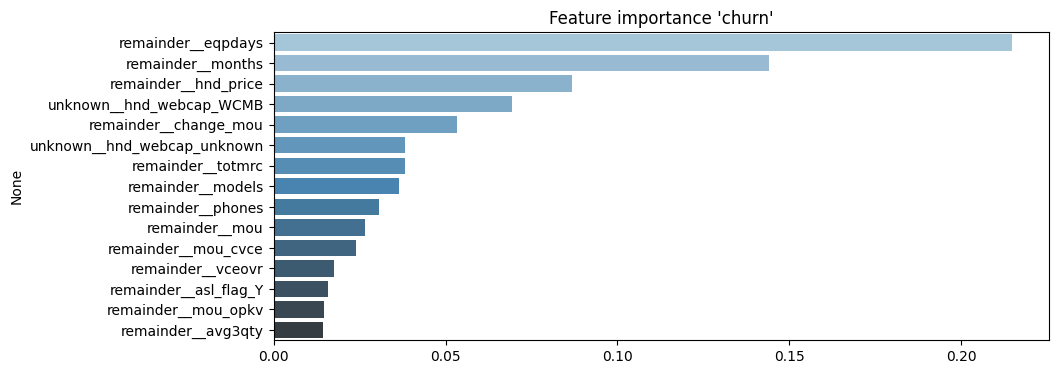

In [146]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df_entrenar_t2.drop(target,axis=1), df_entrenar_t2[target]
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Plotea las 15 mejores Features importances
num_features = 15
features = clf.feature_importances_
columnas = x.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## Split train-test

In [147]:
# se guarda la target como 'y' y las features como 'X'
y = df_entrenar_t2[target]
X = df_entrenar_t2.drop(target, axis=1)

In [148]:
# se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
print('nº observaciones de train:', len(y_train))
print('nº observaciones de test: ', len(y_test))

nº observaciones de train: 35000
nº observaciones de test:  15000


## Rebalanceo del train

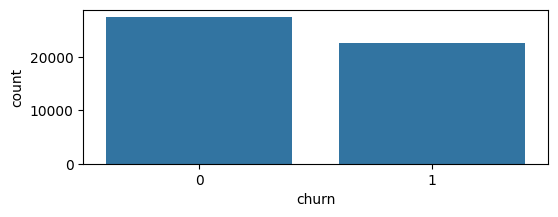

In [150]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(data=df_entrenar_t2, x=target)
plt.show()

In [151]:
# proporción de cada clase de la target
y_train.value_counts(normalize=True)

,proportion
churn,
0,0.549914
1,0.450086


In [152]:
# X_train_0 = X_train.copy()
# y_train_0 = y_train.copy()

# # Crear el undersampler
# undersampler = RandomUnderSampler(sampling_strategy=1.0, replacement=False, random_state=42)  # 1.0 = igualar clases

# # Aplicarlo solo al conjunto de entrenamiento
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

## Estandarización

In [153]:
# guardo las columnas del dataset en una lista antes de standarizar
# el metodo scaler quita el nombre de las variables
# para la interpretabilidad, si el modelo ganador es un arbol de decisión, conviene guardar el nombre de las variables
variables_entrenadas = X.columns

In [154]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
X_predecir = scaler.transform(df_predecir_t2)

## Competición de modelos


Competir sobre el f1_score

In [155]:
# añadimos en una lista los modelos que queremos poner a competir

modelos = []
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_seed=42)))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

In [156]:
# metricas_modelos = pd.DataFrame(columns=['modelo', 'F1_score'])

# for nombre, modelo in modelos:

#     # entrenamos el modelo
#     modelo.fit(X_train, y_train)

#     # hacemos la predicción sobre el dataset de test
#     # al F1_Score se saca con predict_proba.
#     # para el perceptron, usaremos decision_function, el equivalente del predict_proba para este algoritmo
#     y_pred = modelo.predict(X_test)

#     # Calculamos el F1-score
#     f1 = metrics.f1_score(y_test, y_pred)

#     # imprimimos el resultado por modelo
#     metricas_modelos = pd.concat([metricas_modelos,
#                                   pd.DataFrame({'modelo': nombre, 'F1_score': f1}, index=[0])
#                                   ])
#     print(modelo, f1)

# metricas_modelos.sort_values('F1_score', ascending=False)

In [157]:
def curva_auc(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  plt.figure(figsize=(4, 3))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

SGDClassifier(loss='log_loss', random_state=42) 0.7826549029758807 0.6831094472583131


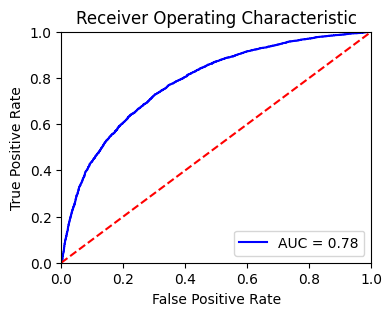

--------------------------------------------------
GradientBoostingClassifier(random_state=42) 0.9057433940979422 0.7960565924142083


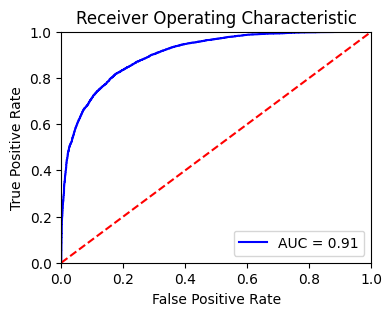

--------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) 0.9421051087211367 0.8463776766395583


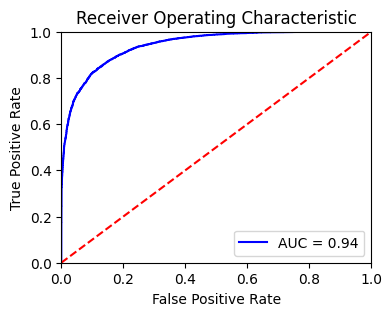

--------------------------------------------------
<catboost.core.CatBoostClassifier object at 0x7b23d6bdafd0> 0.9473470104162572 0.8556901450575743


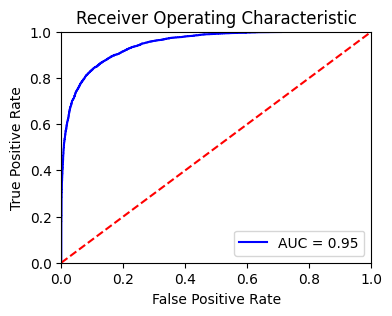

--------------------------------------------------
LogisticRegression(random_state=42) 0.7983760703014852 0.6881493750941123


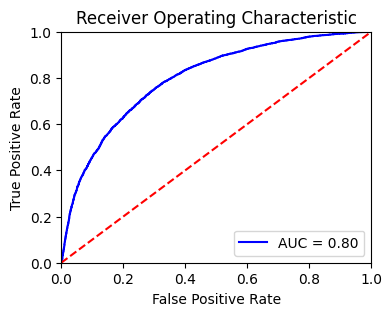

--------------------------------------------------


,modelo,AUC,F1_score
0,CatBoostClassifier,0.947347,0.855690
0,XGBClassifier,0.942105,0.846378
0,GradientBoostingClassifier,0.905743,0.796057
0,LogisticRegression,0.798376,0.688149
0,SGDClassifier,0.782655,0.683109


In [158]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC', 'F1_score'])

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    # al AUC se saca con predict_proba.
    # para el perceptron, usaremos decision_function, el equivalente del predict_proba para este algoritmo
    if nombre == 'Perceptron':
      y_pred = modelo.decision_function(X_test)
    else:
      y_pred_proba = modelo.predict_proba(X_test)[:, 1]
      y_pred= modelo.predict(X_test)

    # calculamos métricas
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    f1_score= metrics.f1_score(y_test, y_pred)


    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'AUC': auc, 'F1_score': f1_score}, index=[0])
                                  ])
    print(modelo, auc, f1_score)
    curva_auc(y_test, y_pred_proba)
    print(50*'-')

metricas_modelos.sort_values('F1_score', ascending=False)



## Hiperparametrización

In [159]:
modelo = CatBoostClassifier(verbose=0, random_seed=42)

In [160]:
# parameters = {
#     'learning_rate': [0.01,0.05, 0.1], # Tasa de aprendizaje
#     'depth': [4,8],  # Profundidad de los árboles
#     'random_strength': [1,10], # Variabilidad para evitar overfitting
#     'iterations': [100, 300],  # Número de arboles

# }

In [161]:
#  grid_search = GridSearchCV(modelo,
#                            parameters,
#                            cv=2,
#                            verbose=True,
#                            scoring = 'f1')

#  grid_search.fit(X_train, y_train)

In [162]:
  # # se imprime el modelo con los mejores parametros
  # grid_search.best_params_

best_params: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1, 'random_strength': 1}

In [163]:

# # se introducen los parametros del griedsearch
# modelo = CatBoostClassifier(depth= 8, iterations= 300, learning_rate= 0.1, verbose= 0, random_strength= 1, random_seed=42)

# modelo.fit(X_train, y_train)
 # y_pred = modelo.predict_proba(X_test)[:, 1]

AUC:0.9445755691606244

F1_score: 0.8509

## Entrenamiento del modelo final

In [164]:
# entrenamiento
modelo =  CatBoostClassifier(verbose=False, random_seed=42)
modelo.fit(X_train, y_train)

In [165]:
# predict
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

In [166]:
y_pred_proba_train = modelo.predict_proba(X_train)
y_pred_proba_test = modelo.predict_proba(X_test)

# Evalucación del modelo final

## AUC

Calcular el AUC con el predict_proba

In [167]:
# predict_proba
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train[:,1])
print('auc train:', auc_train)

auc_test = metrics.roc_auc_score(y_test, y_pred_proba_test[:,1])
print('auc test:', auc_test)

auc train: 0.9823876339602793
auc test: 0.9473470104162572


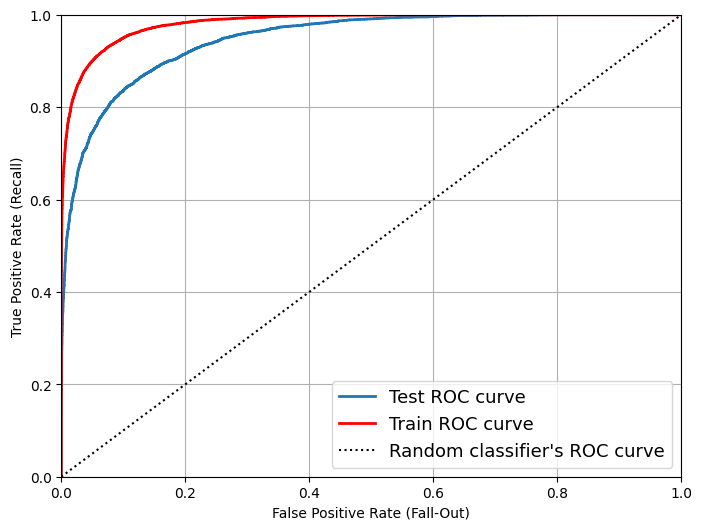

In [168]:
# Visualizacion de la ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="Test ROC curve")
plt.plot(fpr_train, tpr_train, linewidth=2, label="Train ROC curve", color='r')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

## matriz de confusión

In [169]:
# creamos la matriz de confusión
cm_test = metrics.confusion_matrix(y_test, y_pred_test)

[]

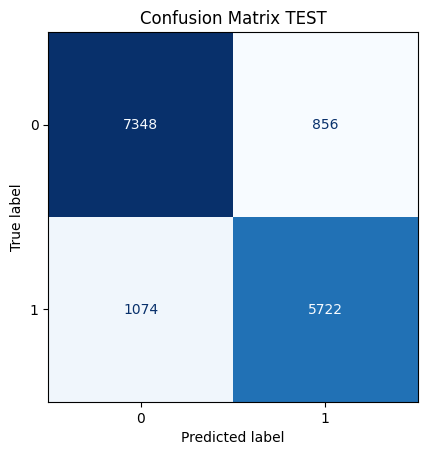

In [170]:
# gráfico de la matriz de confusión en cantidades
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(colorbar = False, cmap = 'Blues')

plt.title('Confusion Matrix TEST')
plt.plot()

## f1_score

In [171]:
accuracy_sklearn = metrics.accuracy_score(y_test, y_pred_test)
precision_sklearn = metrics.precision_score(y_test, y_pred_test)
recall_sklearn = metrics.recall_score(y_test, y_pred_test)
f1_score_sklearn = metrics.f1_score(y_test, y_pred_test)

In [172]:
print('accuracy:', round(accuracy_sklearn,4))
print('precision:', round(precision_sklearn, 4))
print('recall:', round(recall_sklearn, 4))
print('f1_score:', round(f1_score_sklearn, 4))

accuracy: 0.8713
precision: 0.8699
recall: 0.842
f1_score: 0.8557


# Guardar modelo

In [173]:
# Tratamiento de nulos: ColumnTransform()
with open('ct.pkl', 'wb') as f:
    pickle.dump(ct, f)


# oe: Transformación de variables: OneHotEncoder()
with open('oe.pkl', 'wb') as f:
    pickle.dump(oe, f)


# Scaler: Estandarización de variables
with open('scaler.pkl', 'wb') as f:
     pickle.dump(scaler, f)

# modelo: Predicción
with open('modelo.pkl', 'wb') as f:
    pickle.dump(modelo, f)


# Interpretabilidad

## Modelo lineal

Si el mejor modelo ha sido un algoritmo basado en arbole de decisión, entrenamos el mejor modelo lineal de la competición de modelos, sin hiperparametrizar

Imprimir los coeficientes por variable + intercept

In [174]:
modelo_reg_logistic = LogisticRegression(random_state=42)

# entrenamiento
modelo_reg_logistic.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [175]:
# Coeficientes (pesos) de las variables
print("Coeficientes:", modelo_reg_logistic.coef_[0])

# Intercept (constante)
print("Intercept:", modelo_reg_logistic.intercept_)

Coeficientes: [ 0.10503064 -0.11041811 -0.05592858  0.02375589 -0.68647317 -0.22564477
  0.51064829 -0.38937316  0.3402849   0.18132601  0.06727463  0.01859391
  0.08264661 -0.0331082  -0.03397697 -0.01439037 -0.03979306 -0.0545599
 -0.17672712  0.11484049 -0.00191714 -0.00485489 -0.18005493  0.07118076
 -0.21993188 -0.07010129  0.06442758  0.03983124  0.07384023  0.03234229
 -0.05690931 -0.54311082  0.37657199 -0.27342588 -0.49655391  0.58585144
  0.54725161  0.03385822 -0.07361271 -0.13992776  0.1313203   0.03813692
 -0.00948834  0.01257178 -0.00854259  0.75338654  0.04272639 -0.18458205
  0.25781364  0.04845897  0.03989504  0.01119498  0.05109364  0.10752254
 -0.06867543  0.00297201  0.10636847 -0.04113732  0.05229507 -0.07382778
  0.03170723  0.00792694 -0.09268703  0.12134853 -0.02174411  0.054147
 -0.01318058  0.02799776 -0.05656074  0.03133112 -0.02881512 -0.11270259
  0.00880978 -0.04219001  0.01951218 -0.1077804   0.04020606  0.07390019
  0.01549376  0.16281352 -0.10526412  0.

Imprimir los coeficientes de las 10 variables con mayor impacto (positivo o negativo)

In [176]:
# creamos un dataframe con el nombre de las variables para facilitar la vista
coeficientes = pd.DataFrame()
coeficientes['variable'] = variables_entrenadas
coeficientes['coeficiente'] = modelo_reg_logistic.coef_[0]


dict_intercept = {'variable': ['intercept'],
                  'coeficiente':  modelo_reg_logistic.intercept_}
intercept = pd.DataFrame(dict_intercept)

coeficientes = pd.concat([coeficientes, intercept], ignore_index=True)
coeficientes['coeficiente_abs']= coeficientes['coeficiente'].abs()
coeficientes.sort_values('coeficiente_abs', ascending= False).head(10)

,variable,coeficiente,coeficiente_abs
45,remainder__eqpdays,0.753387,0.753387
4,remainder__mou,-0.686473,0.686473
35,remainder__adjmou,0.585851,0.585851
36,remainder__avgrev,0.547252,0.547252
31,remainder__months,-0.543111,0.543111
6,remainder__vceovr,0.510648,0.510648
34,remainder__adjrev,-0.496554,0.496554
7,remainder__change_mou,-0.389373,0.389373
32,remainder__uniqsubs,0.376572,0.376572
8,remainder__change_rev,0.340285,0.340285


## Modelo de árbol de decisión

Si el mejor modelo ha sido un modelo lineal, entrenamos el mejor modelo basado en arboles de decisión, sin hiperparametrizar

&#x26a0;&#xfe0f;
El shap necesita el nombres de las variables. Estandarizar los datos los quita

### Shap values

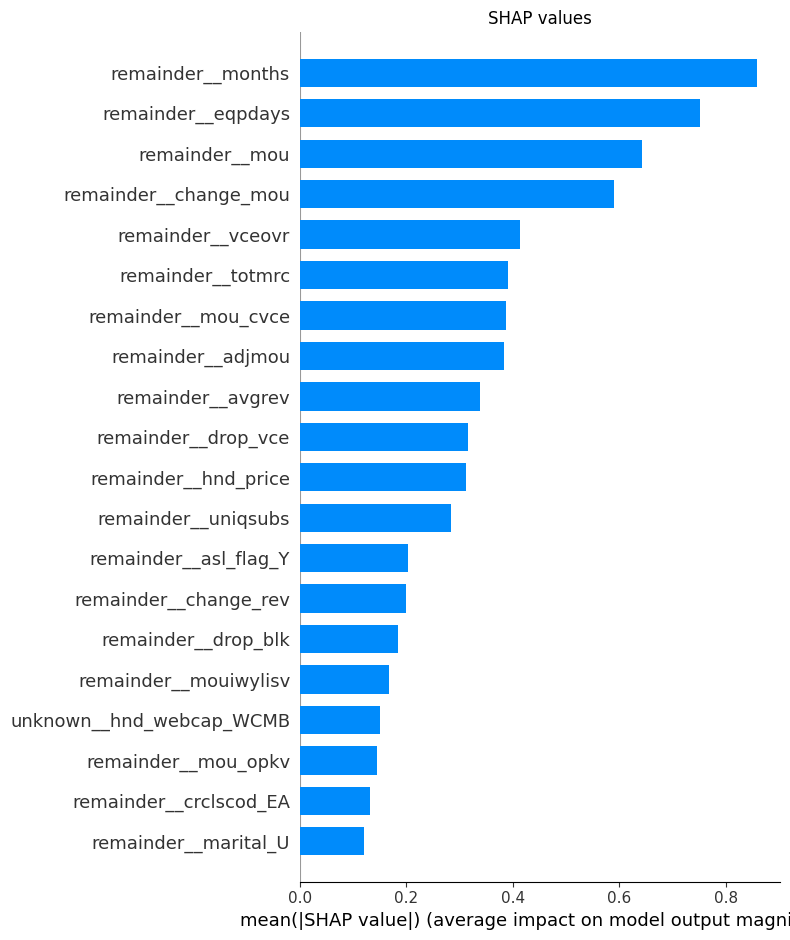

In [177]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

### Summary_plot

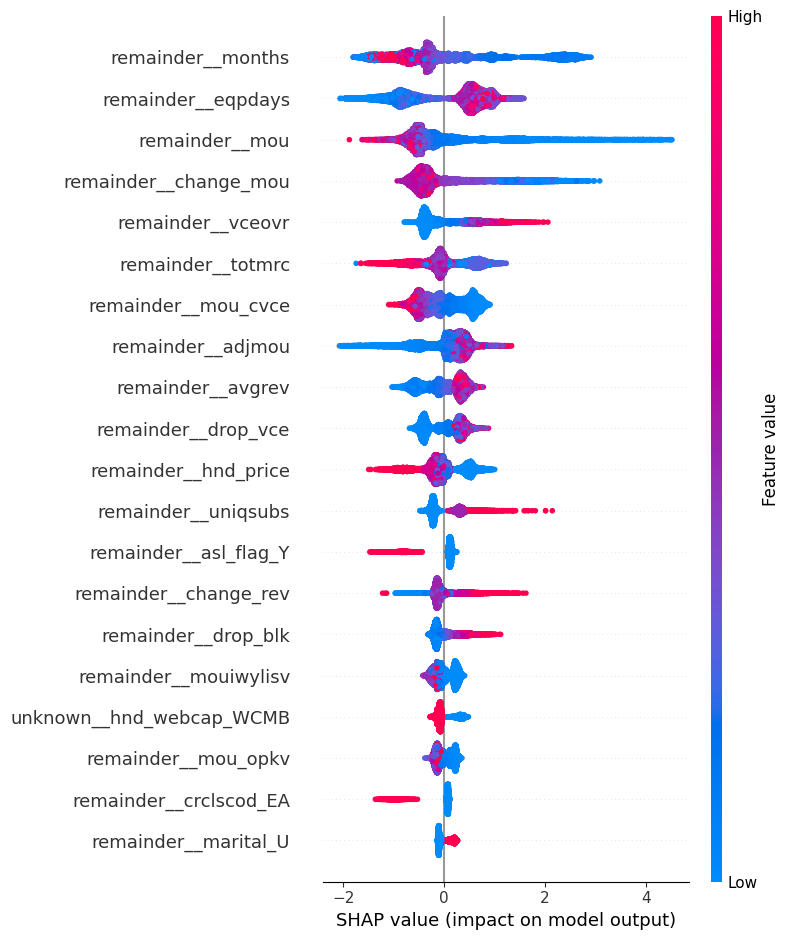

In [178]:
shap.summary_plot(shap_values, X_test)

## Interpretabilidad top 5 variables

Explicar muy brevemente cuales son las 5 variables que más impactan en el churn, y si el impacto es positivo o negativo.

# Predicción

&#x26a0;&#xfe0f;
Realizar la predicción sobre el 100% de los clientes a predecir.  


&#x26a0;&#xfe0f;
Asegurarse de hacer la predicción en las mismas condiciones que el entrenamiento

In [179]:
predict = modelo.predict(X_predecir)
predict_proba = modelo.predict_proba(X_predecir)[:,1]

In [180]:
predict

array([1, 0, 0, ..., 0, 0, 1])

In [181]:
predict_proba

array([9.89792395e-01, 2.32388966e-01, 3.73658953e-01, ...,
       6.86145790e-04, 1.62203553e-02, 8.57561132e-01])

Imprimir los 20 clientes más propensos a irse

In [182]:
df_prediccion = pd.DataFrame()
df_prediccion['customer_id']= cust_id_pred
df_prediccion['predict']= predict
df_prediccion['predict_proba']= predict_proba

df_prediccion.sort_values('predict_proba', ascending= False).head(20)

,customer_id,predict,predict_proba
1085,1065200,1,0.999879
902,1054479,1,0.999828
755,1044403,1,0.999780
449,1025343,1,0.999667
1242,1074314,1,0.999613
501,1028659,1,0.999595
181,1011100,1,0.999515
663,1038632,1,0.999444
828,1049437,1,0.999397
1275,1076249,1,0.999373


Imprimir el len del archivo de predicción

In [183]:
len(df_prediccion)

1500

# Exportar predicción

Exportar un archivo excel con solamente 3 columnas, llamadas 'customer_id', 'predict' y 'predict_proba', **en minúscula**

In [184]:
df_prediccion_export = df_prediccion.copy()
df_prediccion_export.to_excel('df_prediccion_export.xlsx', index=False)

In [185]:
df_prediccion_export_csv = df_prediccion.copy()
df_prediccion_export_csv.to_csv('df_prediccion_export.csv', index=False)